In [60]:
import numpy as np
import math
import matplotlib.pyplot as plt

# LIF model parameters
params = {
    "E_resting": -70.0,   #mV
    "R_m":       10.0,    #MOhm
    "tau_m":     10.0,    #ms
    "V_th":      -54.0,   #mV
    "V_reset":   -80.0    #mV
}


# Simulation parameters
t_start = 0.0    #ms
t_end = 500.0    #ms
dt = 0.1         #ms 
n_steps = int((t_end - t_start) / dt)
time_points = np.linspace(t_start, t_end, n_steps + 1)
current_duration = 300.0   #ms
pulse_start = 100.0        #ms
pulse_end = 400.0          #ms

In [61]:
def current_applied(time, start, end):
    if  (time >= start) and (time < end):
        return True
    else:
        return False

In [62]:
def lif_model(current_amplitude):
    voltage = np.zeros(n_steps+1)
    voltage[0] = params["E_resting"]   #starting V = E 
    
    spike_time = []
    
    for i in range(n_steps):
        input_current = 0.0
        current_time = time_points[i]
        if current_applied(current_time, pulse_start, pulse_end):
            input_current = current_amplitude
            
            
        ## Calculating voltage change with input current 
        alpha = np.exp(-dt/params["tau_m"])
        v_steady = params["E_resting"] + params["R_m"] * input_current
        voltage[i+1] = v_steady + (voltage[i] - (v_steady)) * alpha

        
        if voltage[i+1] >= params["V_th"]:
            spike_time.append(time_points[i+1])
            voltage[i+1] = params["V_reset"]
            
    return time_points, voltage, spike_time

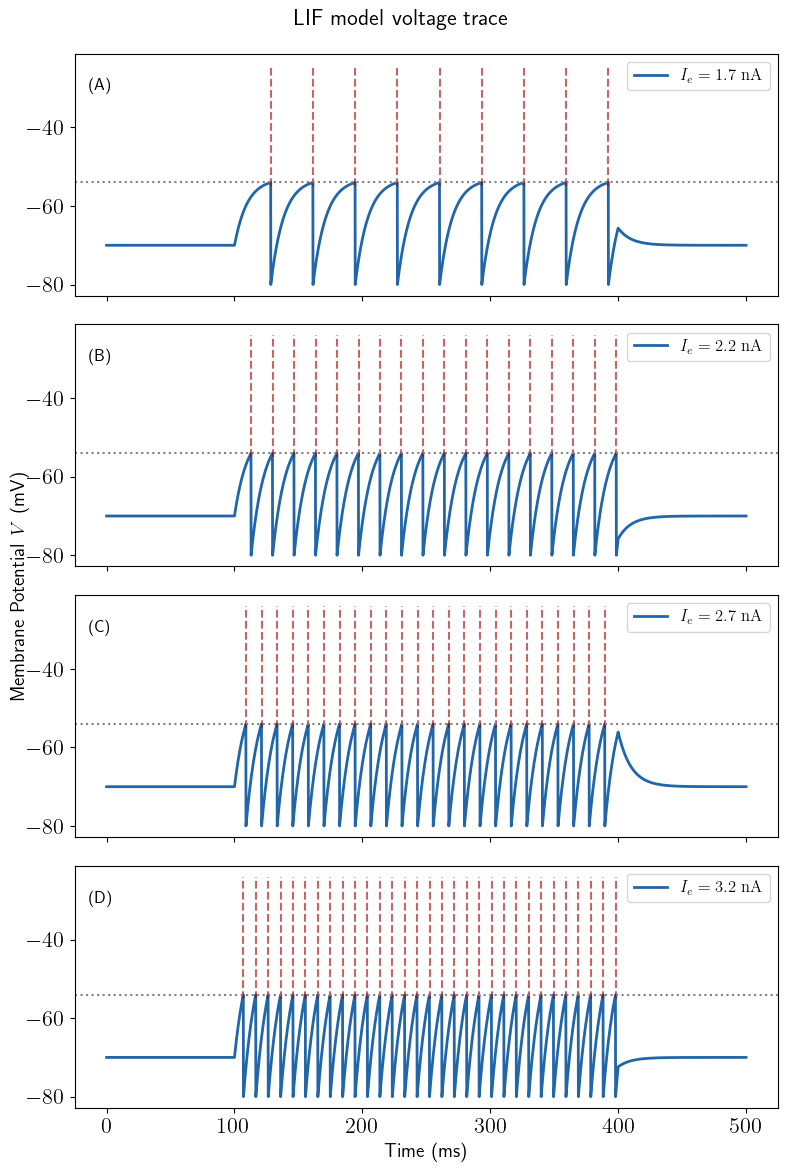

In [58]:
## figures for the voltage trace for 4 different current values


input_currents = [1.7, 2.2, 2.7, 3.2]    #nA
subplot_labels = ['(A)', '(B)', '(C)', '(D)']
plt.rcParams.update({"font.size":16, "text.usetex":True, "figure.figsize":(8, 12)})
fig, axs_b = plt.subplots(4, 1, sharex=True)

for i, I_amp in enumerate(input_currents):
    t, V, spikes = lif_model(I_amp)
    
    ax_b = axs_b[i]
    ax_b.plot(t, V,
             color='#2066a8',
             linewidth=2,
             label=rf'$I_e={I_amp}\ \mathrm{{nA}}$')

    # spikes 
    if spikes:
        bottom = params["V_th"] - 1
        top = params["V_th"] + 30
        ax_b.vlines(spikes,
               ymin=bottom,
               ymax=top,
               color='#a00000', linestyle='--', alpha=0.6)
    
    ax_b.axhline(params["V_th"],
              color='grey', linestyle=':')
    
    ax_b.text(0.02, 0.90, f'{subplot_labels[i]}',
        transform=ax_b.transAxes,
        fontsize=12, fontweight='bold',
        va='top', ha='left')
    
    ax_b.legend(loc='upper right', framealpha=0.8, fontsize=12, markerscale=0.8)


fig.text(0.01, 0.5, r'Membrane Potential $V$ (mV)',
         va='center', rotation='vertical', fontsize=14)

fig.subplots_adjust(left=0.30)

axs_b[-1].set_xlabel('Time (ms)', fontsize=14)
fig.suptitle(rf'LIF model voltage trace', fontsize=16)

plt.tight_layout()
plt.savefig(f'lif_voltage_trace.pdf', dpi=300)
plt.savefig(f'lif_voltage_trace.png', dpi=300)
plt.show()
        
        
    # for s in spikes:
    #     plt.vlines(s,
    #                params["V_th"] - 1,     
    #                params["V_th"] + 30,
    #                color='#a00000', linestyle='--', alpha=0.6)
    # threshold line
    # plt.axhline(params["V_th"],
    #             color='grey', linestyle=':')
    # plt.xlabel(r'Time (ms)')
    # plt.ylabel(r'Membrane Potential $V$ (mV)')
    # plt.title(rf'LIF Voltage Trace, $I_e={I_amp}\,$nA', pad=20)
    # plt.legend(loc='upper right', framealpha=0.8)
    # plt.tight_layout()
    # plt.savefig(f'voltage_trace_{I_amp:.1f}nA.pdf', dpi=300)

In [65]:
def calculating_r_isi(current_amplitude):
    v_alt = (params["R_m"] * current_amplitude) + params["E_resting"]
    t_isi = params["tau_m"] * math.log((v_alt - params["V_reset"]) / (v_alt -  params["V_th"]))
    r_isi = 1000.0 / t_isi    ##time to rate and convert to seconds 
    
    return r_isi

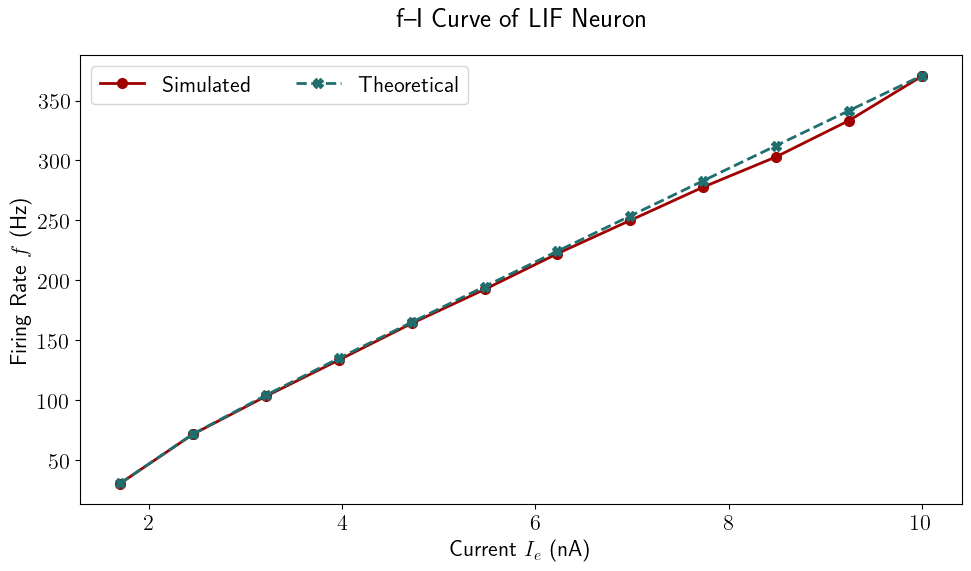

In [67]:
currents = np.linspace(1.7, 10.0, num=12)
sim_rates = []
th_rates = []

for c in currents:
    r_th = calculating_r_isi(c)
    th_rates.append(r_th)

    _, _, spikes = lif_model(c)
    start = pulse_start + params["tau_m"]
    ss_spikes = [s for s in spikes if s > start and s < pulse_end]
    if len(ss_spikes) > 1:
        intervals = np.diff(ss_spikes)
        mean_isi = np.mean(intervals)
        r_sim = 1000.0/mean_isi    ## seconds 
    else:
        r_sim = 0.0
        
    sim_rates.append(r_sim)
    
    
# Plot f–I
plt.figure(figsize=(10,6))
plt.plot(currents, sim_rates, 'o-', color="#a00000", markersize=7, linewidth=2, label='Simulated')
plt.plot(currents, th_rates, 'X--', color='#1f6f6f', markersize=7, linewidth=2, label='Theoretical')
plt.xlabel(r' Current $I_e$ (nA)')
plt.ylabel(r'Firing Rate $f$ (Hz)')
plt.title(rf'f–I Curve of LIF Neuron', pad=20)
plt.legend(ncol=2, loc='upper left', framealpha=0.8)
plt.tight_layout()
plt.savefig('fI_curve_lif.pdf', dpi=300)
plt.savefig('fI_curve_lif.png', dpi=300)